# Homework 2 - ​Predict Future Sales

For all parts below, answer all parts as shown in the Google document for Homework 2. Be sure to include both code that justifies your answer as well as text to answer the questions. Show runtime results for each cell. We also ask that code be commented to make it easier to follow.

## Part 1 - Data Cleaning and Merging

In [ ]:
# TODO: code for data cleaning and merging

Write your answer here

In [308]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [309]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [310]:
cd '/content/gdrive/My Drive/519/HW2'

/content/gdrive/My Drive/519/HW2


In [311]:
# load data
items=pd.read_csv("items.csv")
shops=pd.read_csv("shops.csv")
item_categories=pd.read_csv("item_categories.csv")
train=pd.read_csv("sales_train.csv")
test=pd.read_csv("test.csv")

In [312]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [313]:
# drop duplicates 
subset = ['date','date_block_num','shop_id','item_id','item_cnt_day'] 
print(train.duplicated(subset=subset).value_counts()) 
train.drop_duplicates(subset=subset, inplace=True)
print("shape of train:",train.shape)

False    2935825
True          24
dtype: int64
shape of train: (2935825, 6)


In [314]:
# merge data
train= pd.merge(train,items,on='item_id',how='left')
train= pd.merge(train,item_categories,on='item_category_id',how='left')
train= pd.merge(train,shops,on='shop_id',how='left')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""


In [315]:
perc =[.20, .40, .60, .80,.95,.999] 

with pd.option_context('float_format', '{:.2f}'.format):
  print(train.describe(percentiles = perc).item_price)

count   2935825.00
mean        890.86
std        1729.81
min          -1.00
20%         199.00
40%         349.00
50%         399.00
60%         599.00
80%        1199.00
95%        2690.00
99.9%     23990.00
max      307980.00
Name: item_price, dtype: float64


In [316]:
train['item_price'].sort_values().tail(5)

2931356     42990.0
2327138     49782.0
1488125     50999.0
885130      59200.0
1163150    307980.0
Name: item_price, dtype: float64

>item_price:
>1. Take the max price value as an outlier.<br />
>2. min item_price = -1, replace it with median.

In [317]:
# replace median for price= -1
train[train['item_price']==-1]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
484675,15.05.2013,4,32,2973,-1.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,"Москва ТЦ ""Серебряный Дом"""


In [318]:
price_check = train[(train['item_id']==2973) & (train['shop_id']==32)] # filter
price_check = price_check[price_check['item_price'] > 0 ]                 # get all records for price>0
train.loc[train['item_price']==-1,'item_price']= price_check['item_price'].median()  # replace with median

In [319]:
# delete outliers of item_price
train = train.loc[train['item_price']<100000]

with pd.option_context('float_format', '{:.2f}'.format):
  print(train.describe(percentiles = perc).item_price)

count   2935824.00
mean        890.75
std        1720.50
min           0.07
20%         199.00
40%         349.00
50%         399.00
60%         599.00
80%        1199.00
95%        2690.00
99.9%     23990.00
max       59200.00
Name: item_price, dtype: float64


In [320]:
# delete refund items
train = train.loc[train['item_cnt_day']>0]

with pd.option_context('float_format', '{:.2f}'.format):
  print(train.describe(percentiles = perc).item_cnt_day)

count   2928468.00
mean          1.25
std           2.62
min           1.00
20%           1.00
40%           1.00
50%           1.00
60%           1.00
80%           1.00
95%           2.00
99.9%        22.00
max        2169.00
Name: item_cnt_day, dtype: float64


In [321]:
#check null values
null_values = train.isnull().values.any()
null_values

False

In [49]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""
5,10.01.2013,0,25,2564,349.00,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео,"Москва ТРК ""Атриум"""


## Part 2 - Time Series Analysis

In [ ]:
# TODO: code for time series analysis

Write your answer here

In [322]:
import datetime

train["date"] = pd.to_datetime(train["date"]).dt.strftime('%d/%m/%Y')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,01/02/2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,01/03/2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,01/06/2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,15/01/2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""
5,01/10/2013,0,25,2564,349.00,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео,"Москва ТРК ""Атриум"""


In [323]:
# insert 'weekday', 'month', 'year' column
train.insert(1,"weekday",pd.to_datetime(train["date"]).dt.strftime('%A'))

month = []
for date in train['date'].values:
  d,m,y = date.split("/")
  month.append(m)

train.insert(2,"month",month)

train['year'] = (train['date_block_num'] // 12 ) + 2013
train.head()

,date,weekday,month,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year
0,01/02/2013,Wednesday,02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",2013
1,01/03/2013,Thursday,03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",2013
3,01/06/2013,Sunday,06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",2013
4,15/01/2013,Tuesday,01,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",2013
5,01/10/2013,Thursday,10,0,25,2564,349.00,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео,"Москва ТРК ""Атриум""",2013


In [324]:
# add 'revenue' column
train['revenue'] = train.item_price * train.item_cnt_day
train.head()

,date,weekday,month,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,revenue
0,01/02/2013,Wednesday,02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",2013,999.00
1,01/03/2013,Thursday,03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",2013,899.00
3,01/06/2013,Sunday,06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",2013,1709.05
4,15/01/2013,Tuesday,01,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",2013,1099.00
5,01/10/2013,Thursday,10,0,25,2564,349.00,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео,"Москва ТРК ""Атриум""",2013,349.00


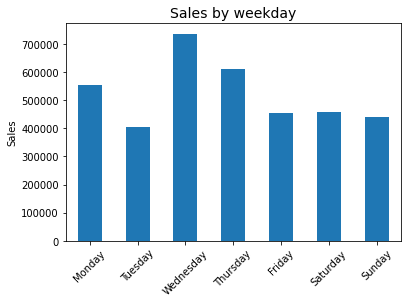

In [325]:
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mons = [ '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

weekday_sale=train.groupby('weekday')['item_cnt_day'].sum()
weekday_sale.index=days
weekday_sale.plot(kind='bar')
plt.title("Sales by weekday", size=14)
plt.xticks(rotation=45)
plt.ylabel('Sales')
plt.show()

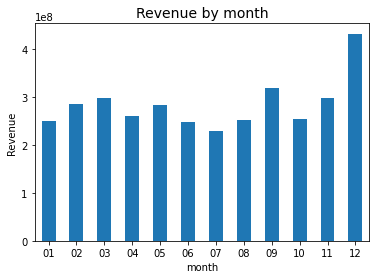

In [326]:
train.groupby('month')['revenue'].sum().plot(kind='bar')
plt.title("Revenue by month", size=14)
plt.xticks(rotation=0)
plt.ylabel('Revenue')
plt.show()

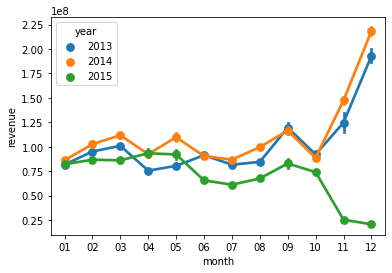

In [327]:
sns.pointplot(x='month', y='revenue', hue='year', data=train, estimator=np.sum)

In [328]:
print("total counts in 2013:",train[train['year']==2013].shape)
print("total counts in 2014:",train[train['year']==2014].shape)
print("total counts in 2015:",train[train['year']==2015].shape)

total counts in 2013: (1264481, 14)
total counts in 2014: (1053199, 14)
total counts in 2015: (610788, 14)


>Explain: <br/>
>1. For weekdays, items are sold more on weekends, and less on workdays. People tend to shop when they are resting at home.
>2. For months, monthly revenue are higher in the 4th season, especially in December. Maybe because there are more holidays like Christmas so that there are more discounts.
>3. We can see that records in 2015 is extremly less than those in 2013 and 2014, and that's why the revenue in 2015 sharply decreased.

## Part 3 - More Time Series Analysis

In [ ]:
# TODO: code for time series analysis

Write your answer here

In [58]:
pip install googletrans

In [329]:
from googletrans import Translator

translator = Translator()
item_categories['item_category_name'] = item_categories['item_category_name'].apply(translator.translate, src='ru', dest='en').apply(getattr, args=('text',))
item_categories.head()

,item_category_name,item_category_id
0,PC - Headsets / Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2
3,Accessories - PS4,3
4,Accessories - PSP,4


In [330]:
# replace with the translated column
train.drop(['item_category_name'],axis=1,inplace=True)
train= pd.merge(train,item_categories,on='item_category_id',how='left')
train.head()

,date,weekday,month,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,year,revenue,item_category_name
0,01/02/2013,Wednesday,02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",2013,999.00,Cinema - Blu-Ray
1,01/03/2013,Thursday,03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",2013,899.00,Music - Vinyl
2,01/06/2013,Sunday,06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",2013,1709.05,Music - Vinyl
3,15/01/2013,Tuesday,01,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",2013,1099.00,Music - branded CD
4,01/10/2013,Thursday,10,0,25,2564,349.00,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,"Москва ТРК ""Атриум""",2013,349.00,Music - Music video


In [331]:
train1 = copy.deepcopy(train)

###Interested Category: Game consoles <br/>

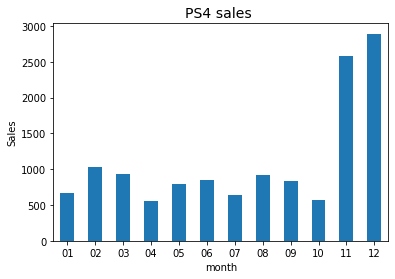

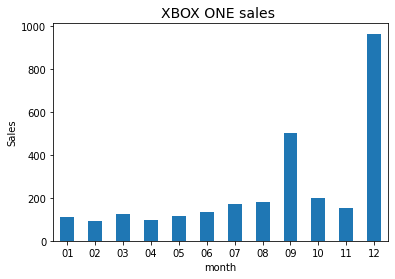

In [332]:
PS4 = train.loc[train['item_category_name']=='Game consoles - PS4']
PS4.groupby('month')['item_cnt_day'].sum().reindex(mons).plot(kind='bar')

plt.title("PS4 sales ", size=14)
plt.xticks(rotation=0)
plt.ylabel('Sales')
plt.show()

Xbox1 = train.loc[train['item_category_name']=='Game consoles - XBOX ONE']
Xbox1.groupby('month')['item_cnt_day'].sum().reindex(mons).plot(kind='bar')

plt.title("XBOX ONE sales ", size=14)
plt.xticks(rotation=0)
plt.ylabel('Sales')
plt.show()

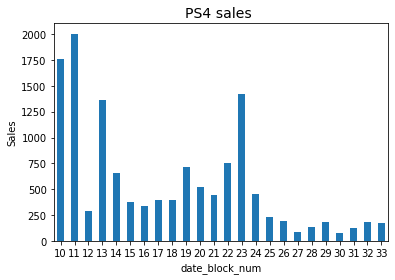

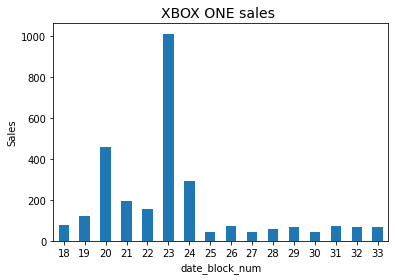

In [333]:
PS4 = train.loc[train['item_category_name']=='Game consoles - PS4']
PS4.groupby('date_block_num')['item_cnt_day'].sum().plot(kind='bar')

plt.title("PS4 sales ", size=14)
plt.xticks(rotation=0)
plt.ylabel('Sales')
plt.show()

Xbox1 = train.loc[train['item_category_name']=='Game consoles - XBOX ONE']
Xbox1.groupby('date_block_num')['item_cnt_day'].sum().plot(kind='bar')

plt.title("XBOX ONE sales ", size=14)
plt.xticks(rotation=0)
plt.ylabel('Sales')
plt.show()


> During 2013-2015, Sony and Microsoft released their newest game consoles: <br/>

*   PS4 was released in 2013.10
*   Xbox One was released in 2014.9

From the plot we can see that here are indeed sales peaks during during this time.  <br/>Also we can see the Chirstmas brings sales peak.

###Item categories with most sales

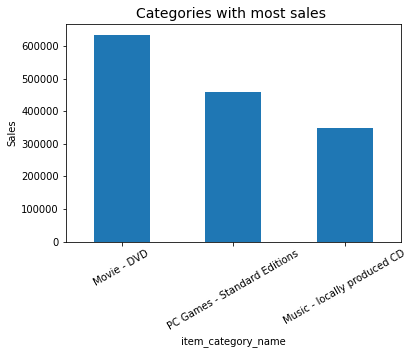

In [334]:
train.groupby('item_category_name')['item_cnt_day'].sum().nlargest(3).plot(kind='bar')

plt.title("Categories with most sales ", size=14)
plt.xticks(rotation=30)
plt.ylabel('Sales')
plt.show()

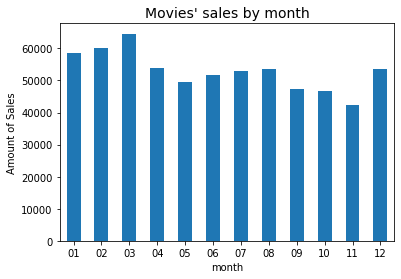

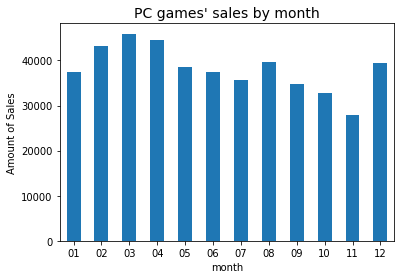

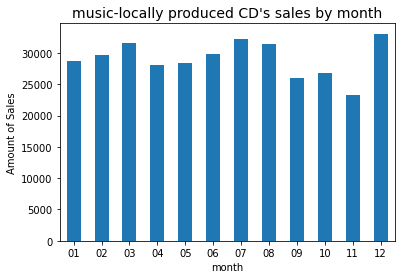

In [335]:
movie = train.loc[train['item_category_name']=='Movie - DVD']
movie.groupby('month')['item_cnt_day'].sum().reindex(mons).plot(kind='bar')


plt.title("Movies' sales by month", size=14)
plt.xticks(rotation=0)
plt.ylabel('Amount of Sales')
plt.show()

PCgames = train.loc[train['item_category_name']=='PC Games - Standard Editions']
PCgames.groupby('month')['item_cnt_day'].sum().reindex(mons).plot(kind='bar')


plt.title("PC games' sales by month", size=14)
plt.xticks(rotation=0)
plt.ylabel('Amount of Sales')
plt.show()

music = train.loc[train['item_category_name']=='Music - locally produced CD']
music.groupby('month')['item_cnt_day'].sum().reindex(mons).plot(kind='bar')

plt.title("music-locally produced CD's sales by month", size=14)
plt.xticks(rotation=0)
plt.ylabel('Amount of Sales')
plt.show()


>Item categories with most sales are: Movie(DVD), PCgames(standard editions), Music(loccally produced CD) <br/>
>All of them have roughly even distribution over the 12 months. So they are not affected much by the holidays.

###Shops with most revenue are: shop #31, #25, #28<br/>


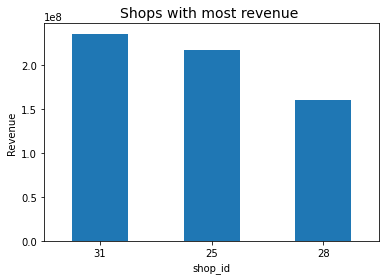

In [336]:
train.groupby('shop_id')['revenue'].sum().nlargest(3).plot(kind='bar')

plt.title("Shops with most revenue ", size=14)
plt.xticks(rotation=0)
plt.ylabel('Revenue')
plt.show()

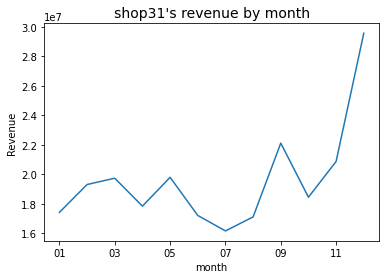

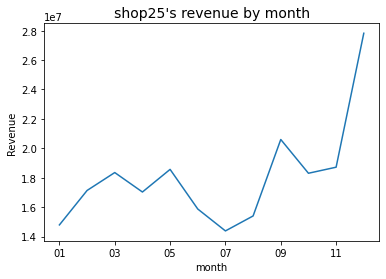

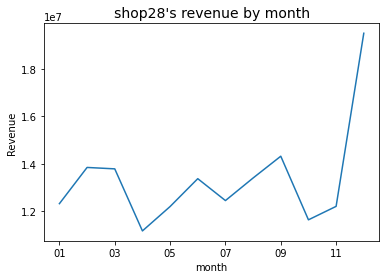

In [337]:
fig = plt.figure()

#plt.subplot(1,3,1)
shop31 = train.loc[train['shop_id']==31]
shop31.groupby('month')['revenue'].sum().reindex(mons).plot()

plt.title("shop31's revenue by month", size=14)
plt.xticks(rotation=0)
plt.ylabel('Revenue')
plt.show()

#plt.subplot(1,3, 2)
shop25 = train.loc[train['shop_id']==25]
shop25.groupby('month')['revenue'].sum().reindex(mons).plot()

plt.title("shop25's revenue by month", size=14)
plt.xticks(rotation=0)
plt.ylabel('Revenue')
plt.show()

#plt.subplot(1,3,3)
shop28 = train.loc[train['shop_id']==28]
shop28.groupby('month')['revenue'].sum().reindex(mons).plot()

plt.title("shop28's revenue by month", size=14)
plt.xticks(rotation=0)
plt.ylabel('Revenue')
plt.show()


>The highest revenue are around 2.5-3+e7 in December, while the lowset revenue are around 1.2+e7. The revenue raised a lot in December because of the Christmas, but other time are evenly distributed.

## Part 4 - Analyze Price Change

In [338]:
# drop shops & items not in test data
test_shops = test.shop_id.unique()
test_items = test.item_id.unique()
train = train[train.shop_id.isin(test_shops)]
train = train[train.item_id.isin(test_items)]
train2 = copy.deepcopy(train)

print('train:', train.shape)

train: (1221488, 14)


In [215]:
last_price=train.groupby(['date_block_num','shop_id','item_id'])[['item_price']].mean().reset_index().rename(columns={'item_price':'last_price'})
last_price.date_block_num=last_price.date_block_num+1
train01=train.merge(last_price,on=['shop_id','item_id','date_block_num'])

In [71]:
train01.head()

,date,weekday,month,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,year,revenue,item_category_name,last_price
0,02/02/2013,Saturday,02,1,50,3851,899.0,1.0,Heavy Rain (Essentials) (с поддержкой PS Move)...,19,"Тюмень ТЦ ""Гудвин""",2013,899.0,Games - PS3,899.0
1,14/02/2013,Thursday,02,1,50,3851,899.0,1.0,Heavy Rain (Essentials) (с поддержкой PS Move)...,19,"Тюмень ТЦ ""Гудвин""",2013,899.0,Games - PS3,899.0
2,27/02/2013,Wednesday,02,1,50,3851,899.0,1.0,Heavy Rain (Essentials) (с поддержкой PS Move)...,19,"Тюмень ТЦ ""Гудвин""",2013,899.0,Games - PS3,899.0
3,02/07/2013,Thursday,07,1,50,3871,2499.0,1.0,"Hitman Absolution [Xbox 360, русская версия]",23,"Тюмень ТЦ ""Гудвин""",2013,2499.0,Games - XBOX 360,2499.0
4,02/11/2013,Monday,11,1,50,3871,2499.0,1.0,"Hitman Absolution [Xbox 360, русская версия]",23,"Тюмень ТЦ ""Гудвин""",2013,2499.0,Games - XBOX 360,2499.0


In [212]:
train1 = copy.deepcopy(train)

In [216]:
train01['price_change']=train01['item_price']/train01['last_price']-1
train01.head(2)

,date,weekday,month,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,year,revenue,item_category_name,last_price_x,last_price_y,last_price,price_change
0,04/06/2013,Saturday,06,3,25,8093,1399.0,1.0,АВАТАР (3D BD+BD+DVD),38,"Москва ТРК ""Атриум""",2013,1399.0,Cinema - Blu-Ray 3D,1381.414286,1381.414286,1381.414286,0.01273
1,04/04/2013,Thursday,04,3,25,8093,1399.0,1.0,АВАТАР (3D BD+BD+DVD),38,"Москва ТРК ""Атриум""",2013,1399.0,Cinema - Blu-Ray 3D,1381.414286,1381.414286,1381.414286,0.01273


In [217]:
train01=train01.dropna()

In [218]:
price_change=train01.groupby(['date_block_num','shop_id','item_id'])[['price_change']].mean().reset_index()
price_change.head()

,date_block_num,shop_id,item_id,price_change
0,3,2,482,0.000000
1,3,2,1916,0.000000
2,3,2,2252,0.000000
3,3,2,2308,-0.078524
4,3,2,2678,0.000000


In [219]:
sale_num=train01.groupby(['date_block_num','shop_id','item_id'])[['item_cnt_day']].sum().reset_index()

###Assume that the price change will affect the sales in a month's time：

In [220]:
# for i in range(1,13):
sale_num.date_block_num=sale_num.date_block_num-1
merge_df=price_change.merge(sale_num,on=['date_block_num','shop_id','item_id'])
corr=merge_df.groupby('date_block_num').apply(lambda x:x[['price_change','item_cnt_day']].corr().iloc[0,1])

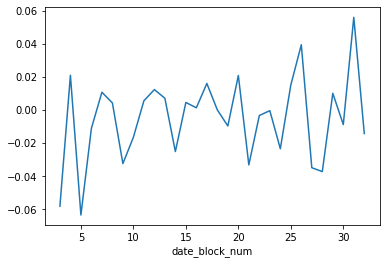

In [221]:
corr.plot()

We can see that, the next month's sales do not have linear relations with the price change. Thus the price change does not affect sales much.

### Plots for the items that have the most price change: 

In [222]:
item_check = train1
item_check['date'] =pd.to_datetime(item_check.date)
item_check['price_change']=0

def groupfunc(group):
    if group['shop_id'].count()>1: # only for those have multiple sale records
        group.sort_values(['date'],inplace=True)
        initial_price = group['item_price'].head(1)
        group['price_change'] = group['item_price'].apply(lambda x:x-initial_price)
    return group

%prun item_check = item_check.groupby(['shop_id','item_id']).apply(groupfunc)

In [223]:
check0 = copy.deepcopy(item_check)
item_check = item_check.sort_values(by=['price_change'])

with pd.option_context('float_format', '{:.2f}'.format):
  print(item_check.describe(percentiles = perc).price_change)

count   527979.00
mean       -68.13
std        576.62
min     -10098.00
20%          0.00
40%          0.00
50%          0.00
60%          0.00
80%          0.00
95%        391.00
99.9%     2363.37
max      57470.00
Name: price_change, dtype: float64


In [224]:
price_decrese_max = item_check.tail(2)
price_decrese_max

,,,date,weekday,month,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,year,revenue,item_category_name,last_price_x,last_price_y,price_change
shop_id,item_id,,,,,,,,,,,,,,,,,,
24,17717,234145,2014-07-29,Tuesday,07,18,24,17717,16790.0,1.0,Прием денежных средств для 1С-Онлайн,79,"Москва ТК ""Буденовский"" (пав.К7)",2014,16790.0,Service,1632.200000,1632.200000,16591.0
12,11365,66854,2013-09-17,Tuesday,09,8,12,11365,59200.0,1.0,Доставка (EMS),9,Интернет-магазин ЧС,2013,59200.0,Delivery of goods,3072.361111,3072.361111,57470.0


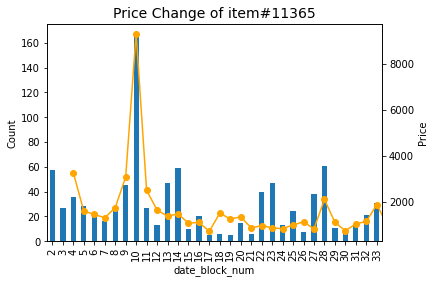

In [225]:
item2 = item_check[(item_check['item_id']==11365) & (item_check['shop_id']==12)]

ax1 = item2.groupby('date_block_num')['item_price'].mean().plot(secondary_y=True,marker = 'o',color='orange')
ax2 = item2.groupby('date_block_num')['item_cnt_day'].sum().plot(kind='bar')

ax2.set_title("Price Change of item#11365", size=14)
ax1.set_ylabel("Price")
ax2.set_ylabel('Count')
plt.show()

>Item with the most price change does not have strong relation to its sales.

## Part 5 - Analyze Item Release Time

In [ ]:
# TODO: code to analyze time since item is released

Write your answer here

In [339]:
subet_date = train[['date','shop_id','item_id']]
df = subet_date.groupby(['item_id','shop_id']).min().reset_index().rename(columns={"date":"date_min_same"})
df_merge = pd.merge(df,df,on='item_id')
df.head()

,item_id,shop_id,date_min_same
0,30,2,03/01/2013
1,30,3,03/08/2013
2,30,4,03/02/2013
3,30,5,03/03/2013
4,30,6,01/06/2015


In [340]:
df_other_shop = df_merge[df_merge['shop_id_x']!=df_merge['shop_id_y']]
df_other_shop = df_other_shop[['item_id','shop_id_x','date_min_same_y']]
df_date_other = df_other_shop.groupby(['item_id','shop_id_x']).min().reset_index()
df_date_other.columns =['item_id','shop_id','date_min_other']
df_release_date = pd.merge(df,df_date_other, on = ['item_id','shop_id'],how = 'left')
df_release_date

,item_id,shop_id,date_min_same,date_min_other
0,30,2,03/01/2013,01/02/2014
1,30,3,03/08/2013,01/02/2014
2,30,4,03/02/2013,01/02/2014
3,30,5,03/03/2013,01/02/2014
4,30,6,01/06/2015,01/02/2014
...,...,...,...,...
111399,22167,53,10/04/2013,01/02/2014
111400,22167,56,05/01/2014,01/02/2014
111401,22167,57,01/10/2014,01/02/2014
111402,22167,58,03/03/2014,01/02/2014


In [342]:
days_diff = pd.merge(train,df_release_date,on=['item_id','shop_id']).dropna()
days_diff.head()

,date,weekday,month,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,year,revenue,item_category_name,date_min_same,date_min_other
0,01/02/2013,Wednesday,02,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",2013,999.0,Cinema - Blu-Ray,01/02/2013,01/02/2013
1,01/03/2013,Thursday,03,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",2013,798.0,Music - locally produced CD,01/02/2015,01/01/2013
2,01/05/2013,Saturday,05,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",2013,399.0,Music - locally produced CD,01/02/2015,01/01/2013
3,01/07/2013,Monday,07,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",2013,399.0,Music - locally produced CD,01/02/2015,01/01/2013
4,01/08/2013,Tuesday,08,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",2013,798.0,Music - locally produced CD,01/02/2015,01/01/2013


In [ ]:
days_diff['date'] =pd.to_datetime(days_diff.date)
days_diff['date_min_same'] =pd.to_datetime(days_diff.date_min_same)
days_diff['date_min_other'] =pd.to_datetime(days_diff.date_min_other)
days_diff['days_selfshop'] = days_diff['date'] - days_diff['date_min_same']
days_diff['days_othershop'] = days_diff['date'] - days_diff['date_min_other']


In [345]:
days_diff.tail()

,date,weekday,month,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,year,revenue,item_category_name,date_min_same,date_min_other,days_selfshop,days_othershop
1221483,2015-10-22,Thursday,10,33,25,7327,349.0,1.0,V/A Deep Calm Mood 2CD (digipack),55,"Москва ТРК ""Атриум""",2015,349.0,Music - locally produced CD,2015-10-18,2015-10-02,4 days,20 days
1221484,2015-10-24,Saturday,10,33,25,7315,399.0,1.0,V/A Dance Kick! 2CD (digipack),55,"Москва ТРК ""Атриум""",2015,399.0,Music - locally produced CD,2015-10-24,2015-10-01,0 days,23 days
1221485,2015-10-31,Saturday,10,33,25,7409,299.0,1.0,V/A Nu Jazz Selection (digipack),55,"Москва ТРК ""Атриум""",2015,299.0,Music - locally produced CD,2015-10-09,2015-10-01,22 days,30 days
1221486,2015-10-09,Friday,09,33,25,7409,299.0,1.0,V/A Nu Jazz Selection (digipack),55,"Москва ТРК ""Атриум""",2015,299.0,Music - locally produced CD,2015-10-09,2015-10-01,0 days,8 days
1221487,2015-10-10,Saturday,10,33,25,7409,299.0,1.0,V/A Nu Jazz Selection (digipack),55,"Москва ТРК ""Атриум""",2015,299.0,Music - locally produced CD,2015-10-09,2015-10-01,1 days,9 days


In [346]:
diff = days_diff[['item_cnt_day','days_selfshop','days_othershop']]
diff['days_selfshop'] = diff['days_selfshop'].dt.days
diff['days_othershop'] = diff['days_othershop'].dt.days

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [356]:
diff = diff[(diff['days_selfshop']>0) & (diff['days_othershop']>0)]
diff.tail(10)

,item_cnt_day,days_selfshop,days_othershop
1221471,10.0,2,3
1221472,3.0,3,4
1221473,2.0,4,5
1221474,4.0,5,6
1221475,1.0,6,7
1221476,4.0,7,8
1221477,1.0,8,9
1221483,1.0,4,20
1221485,1.0,22,30
1221487,1.0,1,9


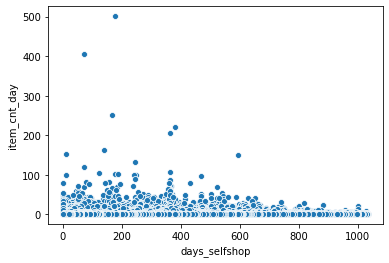

In [355]:
sns.scatterplot(x='days_selfshop', y='item_cnt_day', data=diff)

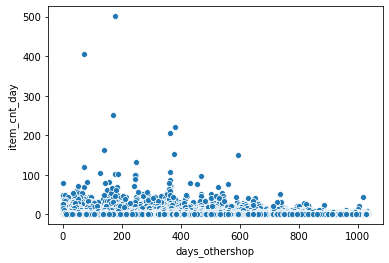

In [358]:
sns.scatterplot(x='days_othershop', y='item_cnt_day', data=diff)

> There is no strong relation betwen the days period and item counts.

## Part 6 - Interesting Plot

In [ ]:
# TODO: code to generate the plot here.

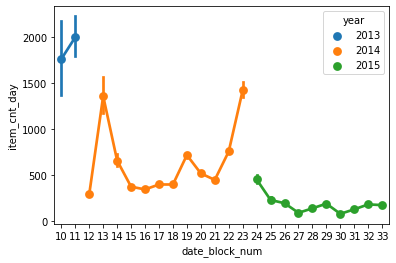

In [359]:
sns.pointplot(x='date_block_num', y='item_cnt_day', hue='year', data=PS4,estimator=np.sum)

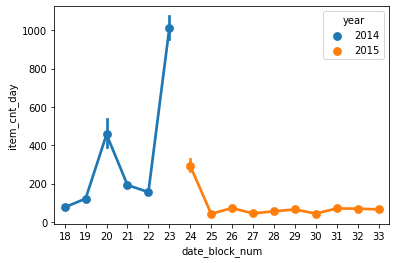

In [360]:
sns.pointplot(x='date_block_num', y='item_cnt_day', hue='year', data=Xbox1,estimator=np.sum)

> Both PS4 and Xbox have a low amount sales after their released time, while only got higher on holidays. Thus for game consoles, the good sales record may not last very long.

In [361]:
item_categories['item_category_type'] = item_categories['item_category_name'].str.split('-').map(lambda x: x[0])
item_categories['item_category_sub_type'] = item_categories['item_category_name'].str.split('-').map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories.head()

,item_category_name,item_category_id,item_category_type,item_category_sub_type
0,PC - Headsets / Headphones,0,PC,Headsets / Headphones
1,Accessories - PS2,1,Accessories,PS2
2,Accessories - PS3,2,Accessories,PS3
3,Accessories - PS4,3,Accessories,PS4
4,Accessories - PSP,4,Accessories,PSP


In [362]:
train= pd.merge(train,item_categories,on='item_category_id',how='left')
train.head()

,date,weekday,month,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,year,revenue,item_category_name_x,item_category_name_y,item_category_type,item_category_sub_type
0,01/02/2013,Wednesday,02,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",2013,999.0,Cinema - Blu-Ray,Cinema - Blu-Ray,Cinema,Blu
1,01/03/2013,Thursday,03,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",2013,798.0,Music - locally produced CD,Music - locally produced CD,Music,locally produced CD
2,01/05/2013,Saturday,05,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",2013,399.0,Music - locally produced CD,Music - locally produced CD,Music,locally produced CD
3,01/07/2013,Monday,07,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",2013,399.0,Music - locally produced CD,Music - locally produced CD,Music,locally produced CD
4,01/08/2013,Tuesday,08,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",2013,798.0,Music - locally produced CD,Music - locally produced CD,Music,locally produced CD


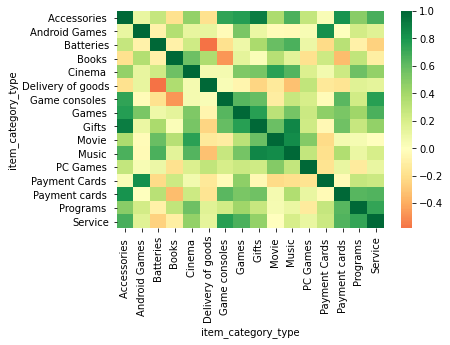

In [363]:
# Exploring data by category
cat_items = train.groupby(['month', 'item_category_type'])[['item_cnt_day']].sum().reset_index()

cat_pivot = cat_items.pivot(index='month', columns='item_category_type', values='item_cnt_day').fillna(0)

# Draw heatmap
corr = cat_pivot.corr()
sns.heatmap(corr, center=0, cmap='RdYlGn')


*   From the heat map we can see taht movies, music, PC games, cinema are all positively correlated. They could all be considered as ways of entertainment. 
*   Another interesting finding is that I assume that PC game will have high relation with Andorid games. But they are not. Since they are all belong to game category, this seems a little strange. <br/>
Maybe it's because the target platform of these two(PC and Android phones) are  different.People are likely to play different kinds of games on these two platforms.

## Part 7 - Prediction Model

In [98]:
from sklearn.preprocessing import LabelEncoder
from itertools import product
from xgboost import XGBRegressor
from xgboost import plot_importance

In [365]:
# load data
items=pd.read_csv("items.csv")
shops=pd.read_csv("shops.csv")
item_categories=pd.read_csv("item_categories.csv")
train=pd.read_csv("sales_train.csv")
test=pd.read_csv("test.csv")

In [366]:
train = train[(train.item_price < 100000 )& (train.item_price > 0)& (train.item_cnt_day < 1000)]
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

In [ ]:
translator = Translator()
item_categories['item_category_name'] = item_categories['item_category_name'].apply(translator.translate, src='ru', dest='en').apply(getattr, args=('text',))

In [368]:
#possess the shop data

train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [369]:
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.head()

,shop_name,shop_id,city,category
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск,"Орджоникидзе,"
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,ТЦ
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ


In [370]:
#Encoding the shop cats so that they can be presented as numbers.
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )

shops = shops[["shop_id", "shop_category", "shop_city"]]
shops.head()

,shop_id,shop_category,shop_city
0,0,4,0
1,1,9,0
2,2,9,1
3,3,7,2
4,4,9,3


In [372]:
# process the item_cat data

item_categories['item_category_type'] = item_categories['item_category_name'].str.split('-').map(lambda x: x[0])
item_categories['item_category_sub_type'] = item_categories['item_category_name'].str.split('-').map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories.head()

,item_category_name,item_category_id,item_category_type,item_category_sub_type
0,PC - Headsets / Headphones,0,PC,Headsets / Headphones
1,Accessories - PS2,1,Accessories,PS2
2,Accessories - PS3,2,Accessories,PS3
3,Accessories - PS4,3,Accessories,PS4
4,Accessories - PSP,4,Accessories,PSP


In [373]:
item_categories['item_category_type_code'] = LabelEncoder().fit_transform(item_categories['item_category_type'])
item_categories['item_category_sub_type_code'] = LabelEncoder().fit_transform(item_categories['item_category_sub_type'])
item_categories = item_categories[['item_category_id','item_category_type_code','item_category_sub_type_code']]
item_categories.head()

,item_category_id,item_category_type_code,item_category_sub_type_code
0,0,15,34
1,1,0,43
2,2,0,44
3,3,0,45
4,4,0,47


In [374]:
matrix = []
#train=train1
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

In [375]:
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)

matrix.sort_values(cols,inplace=True)

In [376]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))

In [377]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [378]:
# predict date should be the 34th month
test['date_block_num'] = 34

In [379]:
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month

In [380]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, item_categories, on=['item_category_id'], how='left')

In [381]:
matrix.drop(['item_name'], axis=1, inplace=True)
matrix.drop(['ID'], axis=1, inplace=True)

In [382]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,item_category_type_code,item_category_sub_type_code
0,0,2,19,0.0,9,1,40,13,20
1,0,2,27,1.0,9,1,19,10,44
2,0,2,28,0.0,9,1,30,16,55
3,0,2,29,0.0,9,1,23,10,61
4,0,2,32,0.0,9,1,40,13,20


In [383]:
#prepare the model
data = matrix
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [38]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 1)

[23:07:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.63887	validation_1-rmse:1.22084
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 1 rounds.
[1]	validation_0-rmse:1.6187	validation_1-rmse:1.20904
[2]	validation_0-rmse:1.59478	validation_1-rmse:1.19135
[3]	validation_0-rmse:1.57197	validation_1-rmse:1.17862
[4]	validation_0-rmse:1.55073	validation_1-rmse:1.16683
[5]	validation_0-rmse:1.52659	validation_1-rmse:1.15394
[6]	validation_0-rmse:1.50818	validation_1-rmse:1.14717
[7]	validation_0-rmse:1.49196	validation_1-rmse:1.13847
[8]	validation_0-rmse:1.47927	validation_1-rmse:1.13106
[9]	validation_0-rmse:1.47032	validation_1-rmse:1.1255
[10]	validation_0-rmse:1.46451	validation_1-rmse:1.12241
[11]	validation_0-rmse:1.45633	validation_1-rmse:1.1175
[12]	validation_0-rmse:1.44745	validation_1-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=300, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, verbosity=1)

In [39]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission.csv', index=False)

I use the XGBRegressor model to do the prediction, and has rmse=1.06.

## Part 8 - Final Result

Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: https://www.kaggle.com/haruka03

Highest Rank: 4977

Score: 1.09659

Number of entries: 1

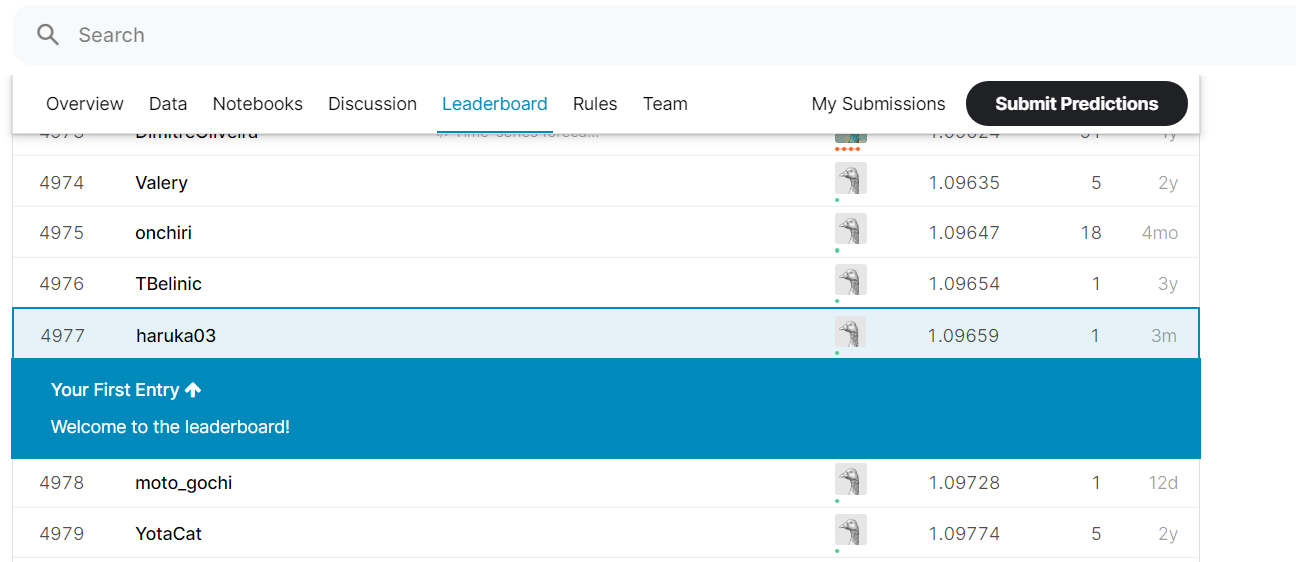

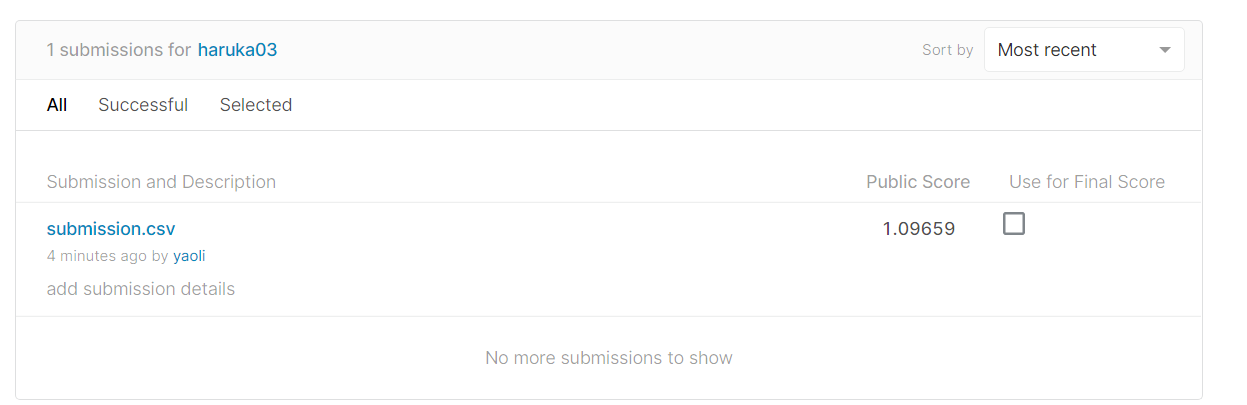